# Quantum Approximate Thermalization [[1](#1)]

There have been many machine learning applications where annealers has been seen to perform the task quite well, but an open ended question remained whether or not near-term circuit model quantum computers would be able to accomplish similar tasks. 

In regard to this Quantum Boltzmann Machines were proposed. These are a type of neural network model in which a network of spins representing bits of data are typically trained to associate a low-energy to the spin representations of a training data-set distribution. The approaches to train these Boltzmann machine rely on
variationally optimizing the network’s energy function. This could be done by employing quantum approximate optimization algorithm (QAOA) as a subroutine on shallow circuits in order to approximately sample from Gibbs states of Ising Hamiltonians and then using it for training.

The protocal begins with the preparation of the state $| \psi_{0} \rangle =\sqrt{2 \cosh \frac{1}{T}} \sum_{\pm} e^{- \frac{\pm }{2T}} |\pm  \rangle_{\mathcal{H_1}} \otimes | \pm  \rangle_{\mathcal{H_2}}$ where $\mathcal{H_1}$ is our current Hilbert space and $\mathcal{H_2}$ is the hilbert such that $| \psi_{0} \rangle \in \mathcal{H_1} \otimes \mathcal{H_2}$ and allows purification of $\rho = \textrm{Tr}_{\mathcal{H_2}} \left( |\psi \rangle \langle \psi | \right)$, in the larger Hilbert space.

In essence, we are marginalizing the probability distribution by tracing out a subsystem of the maximally entangled state to get a thermal state at infinite temperature.

Since state preparation needs low constant depth, it turns out to be quite efficient. In fact, a circuit composed uniquely of RX gates and CNOT gates can be used for it. It can then be shown that by tracing this state over the environment qubits, one recovers the thermal state of $H_M$ , i.e.
$e^{−\beta H_{M}}/tr(e^{−\beta H_{M}})$.


In [1]:
# Libraries Import
import itertools
import numpy as np
from functools import reduce, partial
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Qiskit 
from qiskit import BasicAer, QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import execute
from qiskit.quantum_info import Pauli
from qiskit.aqua import get_aer_backend, QuantumInstance, Operator
from qiskit.aqua.components.initial_states import Custom
backend = BasicAer.get_backend('qasm_simulator')

In [2]:
class QAT:
    def __init__(self, num_qubit, temp, weights, qaoa_step=1):
        self.num_qubits = num_qubit
        self.num_system = num_qubit*2
        self.T = temp
        self.weights = weights
        self.p = qaoa_step
        self.Hc = None
        self.Hm = None
        self.qr = None
        self.cr = None

    def pauli_x(self, qubit, coeff):
        return Operator([[coeff, Pauli(np.zeros(self.num_qubits), np.eye((self.num_qubits))[qubit])]])

    def product_pauli_z(self, q1, q2, coeff):
        return Operator([[coeff, Pauli(np.eye((self.num_system))[q1], np.zeros(self.num_system)) * \
                      Pauli(np.eye((self.num_system))[q2], np.zeros(self.num_system))]])

    def ising_hamiltonian(self):
        Hc = reduce(lambda x,y:x+y,
                [self.product_pauli_z(i,j, -self.weights[i,j])
                for (i,j) in itertools.product(range(self.num_qubits), range(self.num_qubits))])
        
        Hm = reduce(lambda x, y: x+y,
                [self.pauli_x(i, 1) for i in range(self.num_qubits)])
        
        Hc.to_matrix(), 
        Hm.to_matrix()
        return Hc, Hm
    
    def prepare_init_state(self):
        self.qr = QuantumRegister(self.num_system)
        self.cr = ClassicalRegister(self.num_qubits)
        circuit_init = QuantumCircuit(self.qr, self.cr)
        for i in range(self.num_qubits):
            circuit_init.rx( 2 * np.arctan(np.exp(- 1/self.T)), self.num_qubits+i)
            circuit_init.cx(self.num_qubits+i, i)
        return circuit_init
    
    def evolve(self, hamiltonian, angle, quantum_registers):
        return hamiltonian.evolve(None, angle, 'circuit', 1, quantum_registers=quantum_registers,
                                  expansion_mode='suzuki', expansion_order=3)
        
    def evaluate_circuit(self, beta_gamma, circuit_init):
        p = len(beta_gamma)//2
        beta = beta_gamma[:p]; gamma = beta_gamma[p:]
        #print(self.Hc, self.Hm)
        circuit = circuit_init + reduce(lambda x,y: x+y, [self.evolve(self.Hc, beta[i], self.qr) + \
                                self.evolve(self.Hm, gamma[i], self.qr) for i in range(p)])
        return np.real(self.Hc.eval("matrix", circuit, get_aer_backend('statevector_simulator'))[0])
    
    def get_thermal_state(self):
        #print(self.ising_hamiltonian())
        self.Hc, self.Hm = self.ising_hamiltonian()
        #print(self.Hc,self.Hm)
        circuit_init = self.prepare_init_state()
        beta_init = np.random.uniform(0, np.pi*2, self.p)
        gamma_init = np.random.uniform(0, np.pi*2, self.p)   
        evaluate = partial(self.evaluate_circuit, circuit_init=circuit_init)
        result = minimize(evaluate, np.concatenate([beta_init, gamma_init]), method='L-BFGS-B')
        beta = result['x'][:self.p]; gamma = result['x'][self.p:]
        circuit = circuit_init + reduce(lambda x,y: x+y, [self.evolve(self.Hc, beta[i], self.qr) + \
                                self.evolve(self.Hm, gamma[i], self.qr) for i in range(p)])
        return result["fun"], circuit

    def get_energy(self, spin_configuration):
        x = spin_configuration.reshape(-1, 1)
        return np.sum([[-self.weights[i,j] * x[i] * x[j] \
                        for j in range(self.num_qubits)] for i in range(self.num_qubits)])

    def get_energy_distribution(self, thermal_state):
        for i in range(self.num_qubits):
            thermal_state.measure(self.qr[i], self.cr[i])
            job = execute(thermal_state, backend, shots=1000)
        results = job.result().get_counts(thermal_state)
    
        list_spin_configs = np.array(np.concatenate([[list(spin_config)] *\
                                                     results[spin_config] \
                                                     for spin_config in results]), dtype="int")
        list_spin_configs[list_spin_configs == 0] = -1
        list_energy = np.array([self.get_energy(spin_config) for spin_config in list_spin_configs])
        return list_energy

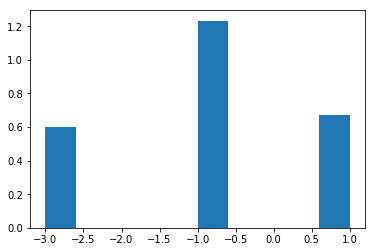

In [3]:
if __name__ == "__main__":
    weights = np.array([[0,1,0],[0,0,1],[0,0,1]])
    p = 5
    r = QAT(3, 1000, weights, p)
    cost, thermal_state = r.get_thermal_state()
    hist = plt.hist(r.get_energy_distribution(thermal_state), density=True)

# References

[1] Verdon, G., Broughton, M., Biamonte, J. (2017) [A quantum algorithm to train neural networks using low-depth circuits](https://arxiv.org/abs/1712.05304). *arXiv:1712.05304*. <a id='1'></a>